# Step-0: Import Libraries

In [1]:
# Visualizations will be shown in the notebook.
%matplotlib inline
from importlib import reload
import python_utils; reload(python_utils)
from python_utils import *

In [2]:
from imgaug import augmenters as iaa

In [3]:
# Import crucial modules
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle
import time

# Load The Data

In [4]:
datasets_path = "F:/Desktop/tsr2/DataSet/german-traffic-signs/"
models_path = "./models/"

training_file = datasets_path + 'train.p'
validation_file= datasets_path + 'valid.p'
testing_file = datasets_path + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Step-1: Dataset Summary & Exploration
The pickled data is a dictionary with 4 key/value pairs:

* 'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
* 'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
* 'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
* 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.
#### THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES

## Providing a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
# Let's get some dimensions
print("Features shape X_train: ", X_train.shape)
print("Features shape y_train: ", y_train.shape)

Features shape X_train:  (34799, 32, 32, 3)
Features shape y_train:  (34799,)


In [6]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Group the images by class
We leverage on the pandas module to group the images by label. Our first step is to import the signnames.csv file which contains English description of the labels.

In [7]:
# Load sign names file
sign_names = pd.read_csv("F:/Desktop/tsr2/DataSet/german-traffic-signs/signnames.csv")
sign_names.set_index("ClassId")

sign_names.head(n=3)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)


In [8]:
########################################################################################################################
######                                        Image processing functions                                          ######
########################################################################################################################


def normalise_images(imgs, dist):
    """
    Normalise the supplied images from data in dist
    """
    std = np.std(dist)
    # std = 128
    mean = np.mean(dist)
    # mean = 128
    return (imgs - mean) / std

def to_grayscale(img):
    """
    Converts an image in RGB format to grayscale
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def augment_imgs(imgs, p):
    """
    Performs a set of augmentations with with a probability p
    """
    augs =  iaa.SomeOf((1, 2),
          [
              iaa.Crop(px=(0, 4)), # crop images from each side by 0 to 4px (randomly chosen)
              iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
              iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
              iaa.Affine(rotate=(-45, 45)), # rotate by -45 to +45 degrees)
              iaa.Affine(shear=(-10, 10)) # shear by -10 to +10 degrees
          ])


    seq = iaa.Sequential([iaa.Sometimes(p, augs)])

    return seq.augment_images(imgs)

def augment_imgs_until_n(imgs, n, p):
    """
    Takes care of augmenting images with a probability p, until n augmentations have been created
    """
    i = 0
    aug_imgs = []
    while i < n:
        augs = augment_imgs(imgs, p)
        i += len(augs)
        aug_imgs = augs if len(aug_imgs) == 0 else np.concatenate((aug_imgs, augs))

    return aug_imgs[0 : n]

In [9]:
########################################################################################################################
######                                        Plot utility functions                                              ######
########################################################################################################################

def plot_results(metrics, axis, lbs, xlb, ylb,  title, fig_size=(7, 5), epochs_interval=10):
    """
    Nifty utility function to plot results of the execution of our model
    """
    fig, ax = plt.subplots(figsize=fig_size)

    total_epochs = metrics[0].shape[0]
    x_values = np.linspace(1, total_epochs, num=total_epochs, dtype=np.int32)

    for m, l in zip(metrics, lbs):
        ax.plot(line1 = ax.plot(x_values, m[:, axis], linewidth=2, label=l))

    ax.set(xlabel=xlb, ylabel=ylb, title=title)
    ax.xaxis.set_ticks(np.linspace(1, total_epochs, num=int(total_epochs/epochs_interval), dtype=np.int32))
    ax.legend(loc='lower right')
    plt.show()

def plot_model_results(metrics, axes, lbs, xlb, ylb, titles, fig_title, fig_size=(7, 5), epochs_interval=10):
    """
    Nifty utility function to plot results of the execution of our model
    """
    fig, axs = plt.subplots(nrows=1, ncols=len(axes), figsize=fig_size)
    print("Length of axis: {0}".format(axs.shape))

    total_epochs = metrics[0].shape[0]
    x_values = np.linspace(1, total_epochs, num=total_epochs, dtype=np.int32)

    for m, l in zip(metrics, lbs):
        for i in range(0, len(axes)):
            ax = axs[i]
            axis = axes[i]
            ax.plot(x_values, m[:, axis], linewidth=2, label=l)
            ax.set(xlabel=xlb[i], ylabel=ylb[i], title=titles[i])
            ax.xaxis.set_ticks(np.linspace(1, total_epochs, num=int(total_epochs/epochs_interval), dtype=np.int32))
            ax.legend(loc='center right')

    plt.suptitle(fig_title, fontsize=14, fontweight='bold')
    plt.show()

def show_image_list(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):
    """
    Utility function to show us a list of traffic sign images
    """
    img_count = len(img_list)
    rows = img_count // cols
    cmap = None

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    for i in range(0, img_count):
        img_name = img_labels[i]     
        img = img_list[i]
        if len(img.shape) < 3 or img.shape[-1] < 3:
            cmap = "gray"
            img = np.reshape(img, (img.shape[0], img.shape[1]))

        if not show_ticks:            
            axes[i].axis("off")
            
#         img = np.clip(img, 0, 1)
        axes[i].imshow(img, cmap=cmap)

    fig.suptitle(title, fontsize=12, fontweight='bold', y = 0.6)
    fig.tight_layout()
    plt.show()

    return

def show_random_dataset_images(group_label, imgs, to_show=5):
    """
    This function takes a DataFrame of items group by labels as well as a set of images and
    randomly selects to_show images to display
    """
    for (lid, lbl), group in group_label:
        # print("[{0}] : {1}".format(lid, lbl))
        rand_idx = np.random.randint(0, high=group['img_id'].size, size=to_show, dtype='int')
        selected_rows = group.iloc[rand_idx]

        selected_img = list(map(lambda img_id: imgs[img_id], selected_rows['img_id']))
        selected_labels = list(map(lambda label_id: label_id, selected_rows['label_id']))
        show_image_list(selected_img, selected_labels, "{0}: {1}".format(lid, lbl), cols=to_show, fig_size=(7, 7), show_ticks=False)






In [10]:
########################################################################################################################
######                                        Data manipulation functions                                         ######
########################################################################################################################

def group_img_id_to_lbl(lbs_ids, lbs_names):    
    """
    Utility function to group images by label 
    """
    arr_map = []
    for i in range(0, lbs_ids.shape[0]):
        label_id = lbs_ids[i]
        label_name = lbs_names[lbs_names["ClassId"] == label_id]["SignName"].values[0]
        arr_map.append({"img_id": i, "label_id": label_id, "label_name": label_name})

    return pd.DataFrame(arr_map)

def group_img_id_to_lb_count(img_id_to_lb):
    """
    Returns a pivot table table indexed by label id and label name, where the aggregate function is count
    """
    return pd.pivot_table(img_id_to_lb, index=["label_id", "label_name"], values=["img_id"], aggfunc='count')

def create_sample_set(grouped_imgs_by_label, imgs, labels, pct=0.4):
    """
    Creates a sample set containing pct elements of the original grouped dataset
    """
    X_sample = []
    y_sample = []

    for (lid, lbl), group in grouped_imgs_by_label:
        group_size = group['img_id'].size
        img_count_to_copy = int(group_size * pct)
        rand_idx = np.random.randint(0, high=group_size, size=img_count_to_copy, dtype='int')

        selected_img_ids = group.iloc[rand_idx]['img_id'].values
        selected_imgs = imgs[selected_img_ids]
        selected_labels = labels[selected_img_ids]
        X_sample = selected_imgs if len(X_sample) == 0 else np.concatenate((selected_imgs, X_sample), axis=0)
        y_sample = selected_labels if len(y_sample) == 0 else np.concatenate((selected_labels, y_sample), axis=0)


    return (X_sample, y_sample)



#### Group Images In Training set

In [11]:
X_train_id_to_label = group_img_id_to_lbl(y_train, sign_names)

In [12]:
# Let's print a few of those mappings now
X_train_id_to_label.head()

,img_id,label_id,label_name
0,0,41,End of no passing
1,1,41,End of no passing
2,2,41,End of no passing
3,3,41,End of no passing
4,4,41,End of no passing


In [13]:
# We should group by label id to understand the distribution
X_train_group_by_label_count = group_img_id_to_lb_count(X_train_id_to_label)

In [14]:
X_train_group_by_label_count.head(n=4)

,,img_id
label_id,label_name,
0,Speed limit (20km/h),180
1,Speed limit (30km/h),1980
2,Speed limit (50km/h),2010
3,Speed limit (60km/h),1260


We can already witness siginificant data imbalance across the classes in the training. For instance class 0 has less than 200 images, while class 2 has over 2000 images. Let's plot the number of images against the class to better understand visually where we stand.

#### Training Set Distribution Visualization

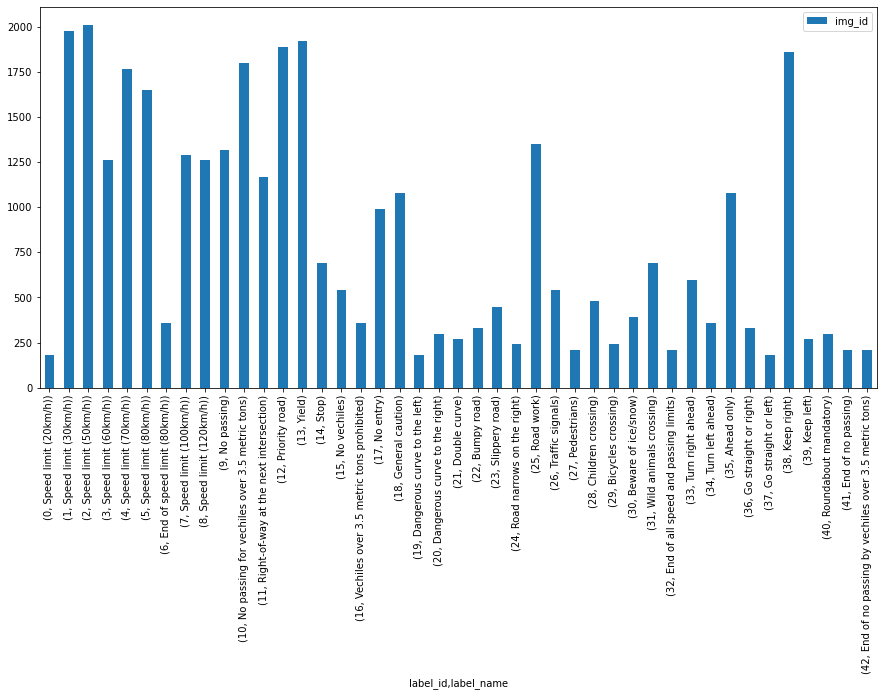

In [15]:
# Now count the number of images for each class and plot the results so that we understand the distribution
X_train_group_by_label_count.plot(kind='bar', figsize=(15, 7))
plt.show()

This confirms the significant class imbalance we observed earlier. At this stage we will not attempt to address it.

#### Training Set Image Visualization

In [16]:
# Let's plot images from each of these classes
X_train_group_by_label = X_train_id_to_label.groupby(["label_id", "label_name"])
img_per_class = 5

# show_random_dataset_images(X_train_group_by_label, X_train)

### Group Images In Validation Set

In [17]:
# Create a data frame whereby we index image id  with label
X_valid_id_to_label = group_img_id_to_lbl(y_valid, sign_names)

In [18]:
# Let's print a few of those mappings now
X_valid_id_to_label.head(n=3)

,img_id,label_id,label_name
0,0,41,End of no passing
1,1,41,End of no passing
2,2,41,End of no passing


In [19]:
# We should group by label id to understand the distribution
X_valid_group_by_label_count = group_img_id_to_lb_count(X_valid_id_to_label)

In [20]:
X_valid_group_by_label_count.head(3)

,,img_id
label_id,label_name,
0,Speed limit (20km/h),30
1,Speed limit (30km/h),240
2,Speed limit (50km/h),240


#### Validation Set Distribution Visualization

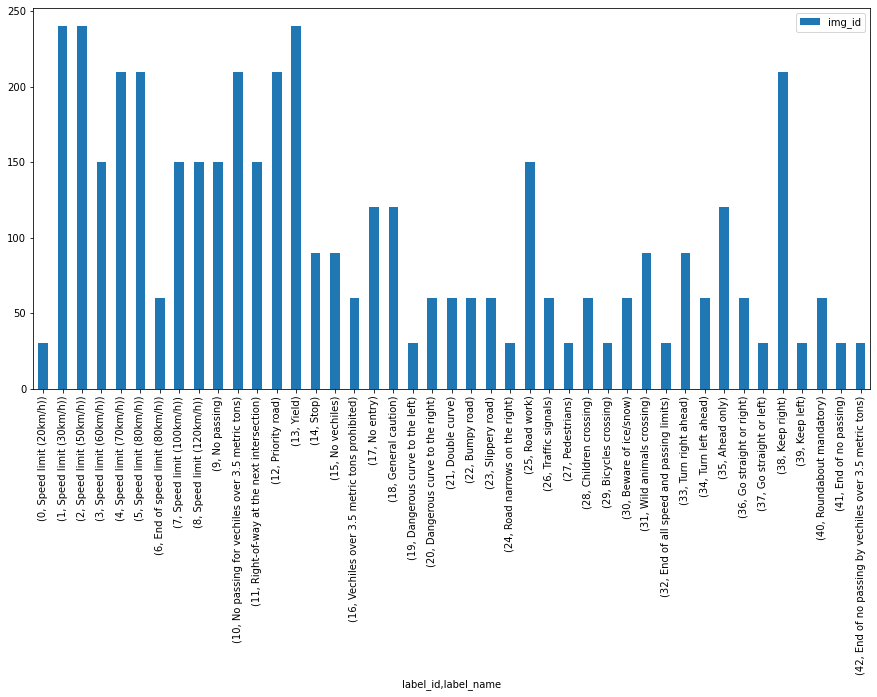

In [21]:
# Now count the number of images for each class and plot the results so that we understand the distribution
X_valid_group_by_label_count.plot(kind='bar', figsize=(15, 7))
plt.show()

We also observe significant imbalance in the validation set. This is honestly less of a problem as we do not train our data on it.

#### Validation Set Images Visualization

In [22]:
# Let's plot images from each of these classes
X_valid_group_by_label = X_valid_id_to_label.groupby(["label_id", "label_name"])

# show_random_dataset_images(X_valid_group_by_label, X_valid)

The validation set seems to suffer from the same problems as the training set, where some images are extremely dark.

#### Create a sample set
As we have over 30 thousand images, we do not want to try every model on the whole dataset as this would be extremely time consuming. Instead, we create sample datasets for training and validation, where we copy a percentage P of both dataset.

In [23]:
X_sample_train, y_sample_train = create_sample_set(X_train_group_by_label, X_train, y_train, pct=0.33)
print("Sample training images dimensions={0}, labels dimensions={1}".format(X_sample_train.shape, y_sample_train.shape))

X_sample_valid, y_sample_valid = create_sample_set(X_valid_group_by_label, X_valid, y_valid, pct=0.33)
print("Sample validation images dimensions={0}, labels dimensions={1}".format(X_sample_valid.shape, y_sample_valid.shape))

Sample training images dimensions=(11464, 32, 32, 3), labels dimensions=(11464,)
Sample validation images dimensions=(1427, 32, 32, 3), labels dimensions=(1427,)


We can see that some images are very dark, and we should therefore look at applying a pre-processing step to brighten them if possible.

# Step 2: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the German Traffic Sign Dataset.

The LeNet-5 implementation shown in the classroom at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission.

There are various aspects to consider when thinking about this problem:

* Neural network architecture (is the network over or underfitting?)
* Play around preprocessing techniques (normalization, rgb to grayscale, etc)
* Number of examples per label (some have more than others).
* Generate fake data.

Here is an example of a published baseline model on this problem. It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

## Data Pre-Processing
Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, (pixel - 128)/ 128 is a quick way to approximately normalize the data and can be used in this project.

Other pre-processing steps are optional. You can try different techniques to see if it improves performance.

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Normalisation
Normalise training, validation & test sets, using mean and standard deviation of training set

In [24]:
# Normalising training set
X_train_normalised = normalise_images(X_train, X_train)

In [25]:
# Normalising validation set
X_valid_normalised = normalise_images(X_valid, X_train) 

In [26]:
# Normalising testing set
X_test_normalised = normalise_images(X_test, X_train)

In [27]:
# show_random_dataset_images(X_valid_group_by_label, X_valid_normalised)


### Grayscale

We can see that grayscaling somewhat improves the visibility of the images, but some of them still remain very dark. At this stage we will not address this problem.

In [28]:
# Let's test our image graying features on training set
X_train_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train))) 
# show_random_dataset_images(X_train_group_by_label, X_train_grayscale)

In [29]:
# Do the same on validation set
X_valid_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_valid))) 
# show_random_dataset_images(X_valid_group_by_label, X_valid_grayscale)

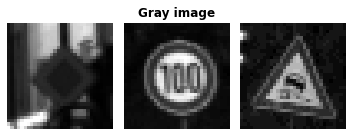

In [30]:
# Also grayscale test data
X_test_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_test))) 
show_image_list(X_test_grayscale[10:13], y_test[10:13], "Gray image", cols=3, fig_size=(5, 8), show_ticks=False)

## Model Architectures
In this section, we will a configurable neural network architecture where the number of layers as well as filter sizes can be modified. But first, we set up the pipeline to enable us to achieve our goal.

### Configuration and Execution Pipeline
We define the steps necessary to build a training pipeline in Tensorflow. These are defined as classes to increase flexibility.

In [31]:
class ModelConfig:
    """
    ModelConfig is a utility class that stores important configuration option about our model
    """

    def __init__(self, model, name, input_img_dimensions, conv_layers_config, fc_output_dims, output_classes, dropout_keep_pct):
        self.model = model
        self.name=name
        self.input_img_dimensions = input_img_dimensions
        
        # Determines the wxh dimension of filters, the starting depth (increases by x2 at every layer) 
        # and how many convolutional layers the network has
        self.conv_filter_size = conv_layers_config[0]
        self.conv_depth_start = conv_layers_config[1]
        self.conv_layers_count = conv_layers_config[2]


        self.fc_output_dims = fc_output_dims 
        self.output_classes = output_classes

        # Try with different values for drop out at convolutional and fully connected layers
        self.dropout_conv_keep_pct = dropout_keep_pct[0]
        self.dropout_fc_keep_pct = dropout_keep_pct[1]

In [32]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [33]:
class ModelExecutor:
    """
    ModelExecutor is responsible for executing the supplied model
    """
    def __init__(self, model_config, learning_rate=0.001):
        self.model_config = model_config
        self.learning_rate = learning_rate
    
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with g.name_scope( self.model_config.name ) as scope:
                # Create Model operations
                self.create_model_operations()

                # Create a saver to persist the results of execution
                self.saver = tf.compat.v1.train.Saver()
    
    def create_placeholders(self):
        """
        Defining our placeholder variables:
            - x, y
            - one_hot_y
            - dropout placeholders
        """

        # e.g. 32 * 32 * 3
        input_dims = self.model_config.input_img_dimensions
        self.x = tf.compat.v1.placeholder(tf.float32, (None, input_dims[0], input_dims[1], input_dims[2]), name="{0}_x".format(self.model_config.name))
        self.y = tf.compat.v1.placeholder(tf.int32, (None), name="{0}_y".format(self.model_config.name))
        self.one_hot_y = tf.one_hot(self.y, self.model_config.output_classes)

        self.dropout_placeholder_conv = tf.compat.v1.placeholder(tf.float32)
        self.dropout_placeholder_fc = tf.compat.v1.placeholder(tf.float32)

    
    def create_model_operations(self):
        """
        Sets up all operations needed to execute run deep learning pipeline
        """

        # First step is to set our x, y, etc
        self.create_placeholders()

        cnn = self.model_config.model

        # Build the network -  TODO: pass the configuration in the future
        self.logits = cnn(self.x, self.model_config, self.dropout_placeholder_conv, self.dropout_placeholder_fc)
        # Obviously, using softmax as the activation function for final layer
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=self.logits)
        # Combined all the losses across batches
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        # What method do we use to reduce our loss?
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=self.learning_rate)
        # What do we really do in a training operation then? Answer: we attempt to reduce the loss using our chosen optimizer
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Get the top prediction for model against labels and check whether they match
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        # Compute accuracy at batch level
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # compute what the prediction would be, when we don't have matching label
        self.prediction = tf.argmax(self.logits, 1)
        # Registering our top 5 predictions
        self.top5_predictions = tf.nn.top_k(tf.nn.softmax(self.logits), k=5, sorted=True, name=None)

        
    def evaluate_model(self, X_data, Y_data, batch_size):
        """
        Evaluates the model's accuracy and loss for the supplied dataset. 
        Naturally, Dropout is ignored in this case (i.e. we set dropout_keep_pct to 1.0)
        """
        
        num_examples = len(X_data)
        total_accuracy = 0.0
        total_loss = 0.0
        sess = tf.get_default_session()

        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = X_data[offset:offset+batch_size], Y_data[offset:offset+batch_size]
            
            # Compute both accuracy and loss for this batch
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })
            loss = sess.run(self.loss_operation, feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })

            # Weighting accuracy by the total number of elements in batch
            total_accuracy += (accuracy * len(batch_x))        
            total_loss += (loss * len(batch_x))            

        # To produce a true mean accuracy over whole dataset
        return (total_accuracy / num_examples, total_loss / num_examples) 
    
    
    def train_model(self, X_train_features, X_train_labels, X_valid_features, y_valid_labels, batch_size=512, epochs=100, PRINT_FREQ=10):
        """
        Trains the model for the specified number of epochs supplied when creating the executor
        """

        # Create our array of metrics    
        training_metrics = np.zeros((epochs, 3))
        validation_metrics = np.zeros((epochs, 3))


        with tf.compat.v1.Session(graph = self.graph, config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:            
            
            sess.run(tf.compat.v1.global_variables_initializer())
            num_examples = len(X_train_features)


            print("Training {0} [epochs={1}, batch_size={2}]...\n".format(self.model_config.name, epochs, batch_size))

            for i in range(epochs):
                start = time.time()
                X_train, Y_train = shuffle(X_train_features, X_train_labels)
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size
                    batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={
                        self.x: batch_x, 
                        self.y: batch_y, 
                        self.dropout_placeholder_conv: self.model_config.dropout_conv_keep_pct,
                        self.dropout_placeholder_fc: self.model_config.dropout_fc_keep_pct,

                    })

                end_training_time = time.time()
                training_duration = end_training_time - start

                #computing training accuracy
                training_accuracy, training_loss = self.evaluate_model(X_train_features, X_train_labels, batch_size)            


                # Computing validation accuracy 
                validation_accuracy, validation_loss = self.evaluate_model(X_valid_features, y_valid_labels, batch_size)


                end_epoch_time = time.time()            
                validation_duration = end_epoch_time - end_training_time   
                epoch_duration = end_epoch_time - start

                if i == 0 or (i+1) % PRINT_FREQ == 0:
                    print("[{0}]\ttotal={1:.3f}s | train: time={2:.3f}s, loss={3:.4f}, acc={4:.4f} | val: time={5:.3f}s, loss={6:.4f}, acc={7:.4f}".format(
                          i+1, epoch_duration, training_duration, training_loss, training_accuracy, 
                        validation_duration, validation_loss, validation_accuracy))

                training_metrics[i] = [training_duration, training_loss, training_accuracy]
                validation_metrics[i] = [validation_duration, validation_loss, validation_accuracy]

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            # Save the model
            self.saver.save(sess, model_file_name)
            print("Model {0} saved".format(model_file_name))

        return (training_metrics, validation_metrics, epoch_duration)
    
    def test_model(self, test_imgs, test_lbs, batch_size=512):
        """
        Evaluates the model with the test dataset and test labels
        Returns the tuple (test_accuracy, test_loss, duration)
        """

        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()

            
            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)

            start = time.time()
            (test_accuracy, test_loss) = self.evaluate_model(test_imgs, test_lbs, batch_size)
            duration = time.time() - start
            print("[{0} - Test Set]\ttime={1:.3f}s, loss={2:.4f}, acc={3:.4f}".format(self.model_config.name, duration, test_loss, test_accuracy))

        
        return (test_accuracy, test_loss, duration)
    
    def predict(self, imgs, top_5=False):
        """
        Returns the predictions associated with a bunch of images
        """
        preds = None
        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            if top_5:
                preds = sess.run(self.top5_predictions, feed_dict={
                        self.x: imgs,
                        self.dropout_placeholder_conv: 1.0,
                        self.dropout_placeholder_fc: 1.0
                    })
            else:
                preds = sess.run(self.prediction, feed_dict={
                    self.x: imgs,
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })
    
        return preds
    
    def show_conv_feature_maps(self, img, conv_layer_idx=0, activation_min=-1, activation_max=-1 ,
                               plt_num=1, fig_size=(15, 15), title_y_pos=1.0):
        """
        Shows the resulting feature maps at a given convolutional level for a SINGLE image
        """
        #s = tf.train.Saver()
        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()
            #tf.reset_default_graph()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            # Run a prediction
            preds = sess.run(self.prediction, feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })

            
            var_name = "{0}/conv_{1}_relu:0".format(self.model_config.name, conv_layer_idx)
            print("Fetching tensor: {0}".format(var_name))
            conv_layer = tf.get_default_graph().get_tensor_by_name(var_name)
            
            activation = sess.run(conv_layer, feed_dict={
                            self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                            self.dropout_placeholder_conv: 1.0,
                            self.dropout_placeholder_fc: 1.0
                            })
            featuremaps = activation.shape[-1]
            # (1, 13, 13, 64)
            print("Shape of activation layer: {0}".format(activation.shape))
            
            #fix the number of columns
            cols = 8
            rows = featuremaps // cols
            fig, axes = plt.subplots(rows, cols, figsize=fig_size)
            k = 0
            for i in range(0, rows):
                for j in range(0, cols):
                    ax = axes[i, j]
                    featuremap = k

                    if activation_min != -1 & activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
                    elif activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
                    elif activation_min !=-1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
                    else:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
                    
                    ax.axis("off")
                    k += 1
            
            fig.suptitle("Feature Maps at layer: {0}".format(conv_layer), fontsize=12, fontweight='bold', y=title_y_pos)
            fig.tight_layout()
            plt.show()

#### EdLeNet
We implement simple variant LeNet by Yann Le Cun, comically named EdLeNet. We make the network highly configurable so that we can assess its different variants and determine which one provides the most accuracy.

In [34]:
from tensorflow.keras.layers import Flatten
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
#tf.keras.layers.Flatten

In [35]:
def EdLeNet(x, mc, dropout_conv_pct, dropout_fc_pct):
    """
    A variant of LeNet created by Yann Le Cun
    The second parameter, which is encapsulates model configuration, enables varying the convolution filter sizes 
    as well as the number of fully connected layers and their output dimensions.
    The third and fourth parameters represent dropout placeholders for convolutional and fully connected layers respectively
    """
    
    # Used for randomly definining weights and biases
    mu = 0
    sigma = 0.1
    
    prev_conv_layer = x
    conv_depth = mc.conv_depth_start
    conv_input_depth = mc.input_img_dimensions[-1]
   
    print("[EdLeNet] Building neural network [conv layers={0}, conv filter size={1}, conv start depth={2}, fc layers={3}]".format(
        mc.conv_layers_count, mc.conv_filter_size, conv_depth, len(mc.fc_output_dims)))
    
    for i in range(0, mc.conv_layers_count):
        # layer depth grows exponentially
        conv_output_depth = conv_depth * (2 ** (i))
        conv_W = tf.Variable(tf.compat.v1.random.truncated_normal(shape=(mc.conv_filter_size, mc.conv_filter_size, conv_input_depth, conv_output_depth), 
                                              mean = mu, stddev = sigma))
        conv_b = tf.Variable(tf.zeros(conv_output_depth))
        
        conv_output = tf.nn.conv2d(prev_conv_layer, conv_W, strides=[1, 1, 1, 1], padding='VALID', name="conv_{0}".format(i)) + conv_b
        conv_output = tf.nn.relu(conv_output, name="conv_{0}_relu".format(i))
        # Traditional max 2x2 pool 
        conv_output = tf.nn.max_pool(conv_output, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        # Apply dropout - even at the conv level
        conv_output = tf.nn.dropout(conv_output, dropout_conv_pct) 
        
        # Setting our loop variables accordingly
        prev_conv_layer = conv_output
        conv_input_depth = conv_output_depth

    
    # Flatten results of second convolutional layer so that it can be supplied to fully connected layer
    fc0   = tf.keras.layers.Flatten()(prev_conv_layer)
    
    # Now creating our fully connected layers
    prev_layer = fc0
    for output_dim in mc.fc_output_dims:
        fcn_W  = tf.Variable(tf.compat.v1.random.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], output_dim), 
                                                 mean = mu, stddev = sigma))
        fcn_b  = tf.Variable(tf.zeros(output_dim))
        
        prev_layer   = tf.nn.dropout(tf.nn.relu(tf.matmul(prev_layer, fcn_W) + fcn_b), dropout_fc_pct)

    
    # Final layer (Fully Connected)
    fc_final_W  = tf.Variable(tf.compat.v1.random.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], mc.output_classes), 
                                                  mean = mu, stddev = sigma))
    fc_final_b  = tf.Variable(tf.zeros(mc.output_classes))
    logits = tf.matmul(prev_layer, fc_final_W) + fc_final_b
    
    return logits

## Train, Validate and Test the Model
### Non-Normalised Images
Let's begin with color and grayscale non-normalised images, changing the feature size

#### Color Sample Set

In [36]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_3x3_Color_Sample", [32, 32, 3], [3, 16, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_5x5_Color_Sample", [32, 32, 3], [5, 16, 2], [120, 84], n_classes, [1.0, 1.0])
mc_7x7 = ModelConfig(EdLeNet, "EdLeNet_7x7_Color_Sample", [32, 32, 3], [7, 16, 2], [120, 84], n_classes, [1.0, 1.0])

In [38]:
me_c_sample_3x3 = ModelExecutor(mc_3x3)
me_c_sample_5x5 = ModelExecutor(mc_5x5)
me_c_sample_7x7 = ModelExecutor(mc_7x7)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=16, fc layers=2]
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=16, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=7, conv start depth=16, fc layers=2]


In [39]:
(c_sample_3x3_tr_metrics, c_sample_3x3_val_metrics, c_sample_3x3_duration) = me_c_sample_3x3.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)
(c_sample_3x3_ts_accuracy, c_sample_3x3_ts_loss, c_sample_3x3_ts_duration) =  me_c_sample_3x3.test_model(X_test, y_test)

Device mapping:

Training EdLeNet_3x3_Color_Sample [epochs=50, batch_size=512]...

[1]	total=41.193s | train: time=21.620s, loss=3.5198, acc=0.1207 | val: time=19.573s, loss=3.5849, acc=0.1212
[10]	total=32.781s | train: time=17.547s, loss=0.4065, acc=0.8941 | val: time=15.234s, loss=1.2658, acc=0.7204
[20]	total=33.500s | train: time=18.422s, loss=0.0737, acc=0.9840 | val: time=15.078s, loss=1.3761, acc=0.7975
[30]	total=35.422s | train: time=20.313s, loss=0.0212, acc=0.9974 | val: time=15.109s, loss=1.5490, acc=0.8171
[40]	total=32.344s | train: time=17.656s, loss=0.0081, acc=0.9996 | val: time=14.687s, loss=1.5444, acc=0.8283
[50]	total=33.000s | train: time=17.672s, loss=0.0028, acc=1.0000 | val: time=15.328s, loss=1.7958, acc=0.8339
Model ./models/EdLeNet_3x3_Color_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/EdLeNet_3x3_Color_Sample.chkpt
[EdLeNet_3x3_Color_Sample - Test Set]	time=15.842s, loss=1.5750, acc=0.8502


In [ ]:
(c_sample_5x5_tr_metrics, c_sample_5x5_val_metrics, c_sample_5x5_duration) = me_c_sample_5x5.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)
(c_sample_5x5_ts_accuracy, c_sample_5x5_ts_loss, c_sample_5x5_ts_duration) =  me_c_sample_5x5.test_model(X_test, y_test)

In [ ]:
(c_sample_7x7_tr_metrics, c_sample_7x7_val_metrics, c_sample_7x7_duration) = me_c_sample_7x7.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)
(c_sample_7x7_ts_accuracy, c_sample_7x7_ts_loss, c_sample_7x7_ts_duration) =  me_c_sample_7x7.test_model(X_test, y_test)

The 3x3 model has much lower loss than the other two on the validation and test sets. We may be tempted to exclusively focus on it, but instead we will run the 3x3 and 5x5 models side by side, as the 7x7 one seems to produce the worst results.

In [ ]:
metrics_arr = [c_sample_7x7_tr_metrics, c_sample_7x7_val_metrics, c_sample_5x5_tr_metrics, c_sample_5x5_val_metrics, c_sample_3x3_tr_metrics, c_sample_3x3_val_metrics]
lbs = ["7x7 training", "7x7 validation", "5x5 training", "7x7 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color  - Accuracy and Loss of models on sample set"
                    , fig_size=(17, 5))

#### Color Full Dataset
We now run the 3x3 and 5x5 models on the full color dataset. We also took the liberty to increase the depth of our convolutional layers as we have observed better information starting at 32, rather than 16.

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Full_Color_3x3", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Full_Color_5x5", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [ ]:
me_c_3x3 = ModelExecutor(mc_3x3)
me_c_5x5 = ModelExecutor(mc_5x5)

In [ ]:
(c_3x3_tr_metrics, c_3x3_val_metrics, c_3x3_duration) = me_c_3x3.train_model(X_train, y_train, X_valid, y_valid, epochs=100)
(c_3x3_ts_accuracy, c_3x3_ts_loss, c_3x3_ts_duration) =  me_c_3x3.test_model(X_test, y_test)

In [ ]:
(c_5x5_tr_metrics, c_5x5_val_metrics, c_5x5_duration) = me_c_5x5.train_model(X_train, y_train, X_valid, y_valid, epochs=100)
(c_5x5_ts_accuracy, c_5x5_ts_loss, c_5x5_ts_duration) =  me_c_5x5.test_model(X_test, y_test)

In [ ]:
metrics_arr = [c_5x5_tr_metrics, c_5x5_val_metrics, c_3x3_tr_metrics, c_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

Interesting, the 5x5 model is the one that shows the most overfit, and produces significantly higher losses than the 3x3 model, which manages to approach 93% accuracy on both validation and test sets, while not quite getting there. This could be due to the fact that we have a deeper network that uses less coarse convolutions and therefore is able to extract more features. We are next going to test the model on grayscale images.

### Grayscale Full Dataset

In [ ]:
# Reshaping our inputs to a format that tensorflow accepts (i.e. a 4D tensor)
X_train_grayscale = np.reshape(X_train_grayscale, (X_train_grayscale.shape[0], 32, 32, 1))
X_valid_grayscale = np.reshape(X_valid_grayscale, (X_valid_grayscale.shape[0], 32, 32, 1))
X_test_grayscale = np.reshape(X_test_grayscale, (X_test_grayscale.shape[0], 32, 32, 1))

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [ ]:
me_g_3x3 = ModelExecutor(mc_3x3)
me_g_5x5 = ModelExecutor(mc_5x5)

In [ ]:
(g_3x3_tr_metrics, g_3x3_val_metrics, g_3x3_duration) = me_g_3x3.train_model(X_train_grayscale, y_train, X_valid_grayscale, y_valid, epochs=100)
(g_3x3_ts_accuracy, g_3x3_ts_loss, g_3x3_ts_duration) =  me_g_3x3.test_model(X_test_grayscale, y_test)

In [ ]:
(g_5x5_tr_metrics, g_5x5_val_metrics, g_5x5_duration) = me_g_5x5.train_model(X_train_grayscale, y_train, X_valid_grayscale, y_valid, epochs=100)
(g_5x5_ts_accuracy, g_5x5_ts_loss, g_5x5_ts_duration) =  me_g_5x5.test_model(X_test_grayscale, y_test)

In [ ]:
metrics_arr = [g_5x5_tr_metrics, g_5x5_val_metrics, g_3x3_tr_metrics, g_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

Once again, the 3x3 model outperforms the 5x5 one on validation and test accuracy. We can see that both models' validation losses are increasing as the training accuracy improves. This is a strong suggestion that overfitting is occuring.

## Normalised Images
We now assess the model on normnalised images, which should presumably allow faster convergence on both training and validation sets.

### Color

In [37]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_3x3", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_5x5", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [38]:
me_c_norm_3x3 = ModelExecutor(mc_3x3)
me_c_norm_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [ ]:
(c_norm_3x3_tr_metrics, c_norm_3x3_val_metrics, c_norm_3x3_duration) = me_c_norm_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_3x3_ts_accuracy, c_norm_3x3_ts_loss, c_norm_3x3_ts_duration) =  me_c_norm_3x3.test_model(X_test_normalised, y_test)

In [ ]:
(c_norm_5x5_tr_metrics, c_norm_5x5_val_metrics, c_norm_5x5_duration) = me_c_norm_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_5x5_ts_accuracy, c_norm_5x5_ts_loss, c_norm_5x5_ts_duration) =  me_c_norm_5x5.test_model(X_test_normalised, y_test)

In [ ]:
metrics_arr = [c_norm_5x5_tr_metrics, c_norm_5x5_val_metrics, c_norm_3x3_tr_metrics, c_norm_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color (Normalised)  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

Interesting, this time the roles are reversed: the 3x3 is performing worse on test and validation sets. I don't have a clear explanation, apart from overfitting happening much more quickly with the 3x3 model. We turn next to grayscale normalised images.

### Grayscale

In [ ]:
# Normalise grayscale images too
X_train_grayscale_normalised = normalise_images(X_train_grayscale, X_train_grayscale)
X_valid_grayscale_normalised = normalise_images(X_valid_grayscale, X_train_grayscale)
X_test_grayscale_normalised = normalise_images(X_test_grayscale, X_train_grayscale)

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [ ]:
me_g_norm_3x3 = ModelExecutor(mc_3x3)
me_g_norm_5x5 = ModelExecutor(mc_5x5)

In [ ]:
(g_norm_3x3_tr_metrics, g_norm_3x3_val_metrics, g_norm_3x3_duration) = me_g_norm_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_3x3_ts_accuracy, g_norm_3x3_ts_loss, g_norm_3x3_ts_duration) =  me_g_norm_3x3.test_model(X_test_grayscale_normalised, y_test)

In [ ]:
(g_norm_5x5_tr_metrics, g_norm_5x5_val_metrics, g_norm_5x5_duration) = me_g_norm_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_5x5_ts_accuracy, g_norm_5x5_ts_loss, g_norm_5x5_ts_duration) =  me_g_norm_5x5.test_model(X_test_grayscale_normalised, y_test)

In [ ]:
metrics_arr = [g_norm_5x5_tr_metrics, g_norm_5x5_val_metrics, g_norm_3x3_tr_metrics, g_norm_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale (Normalised)  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

The 3x3 nodel shows more erratic behaviour, which is hard to explain at this stage. Overall, it performs slighty better. Sadly none of the 2 model reach 93% test accuracy. It is time to set our eyes on dropout.

## Dropout - Keep 75% of weights in Fully Connected Layers
Let's start with a keep percentage of 75% to see what kind of results we get... We will also keep weights in the convolutional layers with a probability of 90%.

### Color (Normalised)

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_3x3_Color_Dropout_0.75", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [0.9, 0.75])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_3x3_Color_Dropout_0.75", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [0.9, 0.75])

In [ ]:
me_c_norm_drpt_0_75_3x3 = ModelExecutor(mc_3x3)
me_c_norm_drpt_0_75_5x5 = ModelExecutor(mc_5x5)

In [ ]:
(c_norm_drpt_0_75_3x3_tr_metrics, c_norm_drpt_0_75_3x3_val_metrics, c_norm_drpt_0_75_3x3_duration) = me_c_norm_drpt_0_75_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(_c_norm_drpt_0_75_3x3_ts_accuracy, c_norm_drpt_0_75_3x3_ts_loss, c_norm_drpt_0_75_ts_duration) =  me_c_norm_drpt_0_75_3x3.test_model(X_test_normalised, y_test)

In [ ]:
(c_norm_drpt_0_75_5x5_tr_metrics, c_norm_drpt_0_75_5x5_val_metrics, c_norm_drpt_0_75_5x5_duration) = me_c_norm_drpt_0_75_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_drpt_0_75_5x5_ts_accuracy, c_norm_drpt_0_75_5x5_ts_loss, c_norm_drpt_0_75_5x5_ts_duration) =  me_c_norm_drpt_0_75_5x5.test_model(X_test_normalised, y_test)

In [ ]:
metrics_arr = [c_norm_drpt_0_75_5x5_tr_metrics, c_norm_drpt_0_75_5x5_val_metrics, c_norm_drpt_0_75_3x3_tr_metrics, c_norm_drpt_0_75_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color (Normalised) - Accuracy and Loss of models with dropout (p-conv=0.9, p-fc=0.75)"
                    , fig_size=(17, 5))

We are seeing some gret results with the introduction of dropout. The 5x5 model achieves above 96% accuracy while the 3x3 model achieves over 97% test accuracy. We should get similar, if not better results, with grayscale images.

### Grayscale (Normalised)

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_3x3_Dropout_0.75", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.9, 0.75])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_5x5_Dropout_0.75", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [0.9, 0.75])

In [ ]:
me_g_norm_drpt_0_75_3x3 = ModelExecutor(mc_3x3)
me_g_norm_drpt_0_75_5x5 = ModelExecutor(mc_5x5)

In [ ]:
(g_norm_drpt_0_75_3x3_tr_metrics, g_norm_drpt_0_75_3x3_val_metrics, g_norm_drpt_0_75_3x3_duration) = me_g_norm_drpt_0_75_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_75_3x3_ts_accuracy, g_norm_drpt_0_75_3x3_ts_loss, g_norm_drpt_0_75_ts_3x3_duration) =  me_g_norm_drpt_0_75_3x3.test_model(X_test_grayscale_normalised, y_test)

In [ ]:
(g_norm_drpt_0_75_5x5_tr_metrics, g_norm_drpt_0_75_5x5_val_metrics, g_norm_drpt_0_75_5x5_duration) = me_g_norm_drpt_0_75_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_75_5x5_ts_accuracy, g_norm_drpt_0_75_5x5_ts_loss, g_norm_drpt_0_75_ts_5x5_duration) =  me_g_norm_drpt_0_75_5x5.test_model(X_test_grayscale_normalised, y_test)

In [ ]:
metrics_arr = [g_norm_drpt_0_75_5x5_tr_metrics, g_norm_drpt_0_75_5x5_val_metrics, g_norm_drpt_0_75_3x3_tr_metrics, g_norm_drpt_0_75_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale (Normalised) - Accuracy and Loss of models with dropout (p-conv=0.9, p-fc=0.75)"
                    , fig_size=(17, 5))

Once again, both 3x3 and 5x5 variants are very close, accuracy-wise on all dataset types. Interestingly, the 3x3 model achieves lower loss but also lower accuracy than its counterpart 3x3 model on color images. We should do more runs of those models to determine which one performs better over the long run in the future. But We believe that we don't need to go that far: we can use even more aggressive dropout values to obtain better results.

## Dropout - Keep Fully Connected Weights with a 50% probability
### Grayscale

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Norm_Grayscale_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.75, 0.5])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Norm_Grayscale_5x5_Dropout_0.50", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [0.75, 0.5])

In [ ]:
me_g_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3)
me_g_norm_drpt_0_50_5x5 = ModelExecutor(mc_5x5)

In [ ]:
(g_norm_drpt_0_50_3x3_tr_metrics, g_norm_drpt_0_50_3x3_val_metrics, g_norm_drpt_0_50_3x3_duration) = me_g_norm_drpt_0_50_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_50_3x3_ts_accuracy, g_norm_drpt_0_50_3x3_ts_loss, g_norm_drpt_0_50_ts_3x3_duration) =  me_g_norm_drpt_0_50_3x3.test_model(X_test_grayscale_normalised, y_test)

In [ ]:
(g_norm_drpt_0_50_5x5_tr_metrics, g_norm_drpt_0_50_5x5_val_metrics, g_norm_drpt_0_50_5x5_duration) = me_g_norm_drpt_0_50_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_50_5x5_ts_accuracy, g_norm_drpt_0_50_5x5_ts_loss, g_norm_drpt_0_50_ts_5x5_duration) =  me_g_norm_drpt_0_50_5x5.test_model(X_test_grayscale_normalised, y_test)

In [ ]:
metrics_arr = [g_norm_drpt_0_50_5x5_tr_metrics, g_norm_drpt_0_50_5x5_val_metrics, g_norm_drpt_0_50_3x3_tr_metrics, g_norm_drpt_0_50_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale (normalised)  - Accuracy and Loss of models with dropout (p-conv=0.75, p-fc=0.5)"
                    , fig_size=(17, 5))

Both models show smooth, satisfying on the curves. The 3x3 model clearly seems to perform the best. While we are able to score above 98% accuracy on vaidation set, we have not been able to break through this barrier yet on the test set, but we are close!

### Color

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_3x3_Dropout_0.40", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [0.75, 0.5])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_5x5_Dropout_0.40", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [0.75, 0.5])

In [ ]:
me_c_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
me_c_norm_drpt_0_50_5x5 = ModelExecutor(mc_5x5, learning_rate=0.001)

In [ ]:
(c_norm_drpt_0_50_3x3_tr_metrics, c_norm_drpt_0_50_3x3_val_metrics, c_norm_drpt_0_50_3x3_duration) = me_c_norm_drpt_0_50_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_drpt_0_50_3x3_ts_accuracy, c_norm_drpt_0_50_3x3_ts_loss, c_norm_drpt_0_50_3x3_ts_duration) =  me_c_norm_drpt_0_50_3x3.test_model(X_test_normalised, y_test)

In [ ]:
(c_norm_drpt_0_50_5x5_tr_metrics, c_norm_drpt_0_50_5x5_val_metrics, c_norm_drpt_0_50_5x5_duration) = me_c_norm_drpt_0_50_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_drpt_0_50_5x5_ts_accuracy, c_norm_drpt_0_50_5x5_ts_loss, c_norm_drpt_0_50_5x5_ts_duration) =  me_c_norm_drpt_0_50_5x5.test_model(X_test_normalised, y_test)

In [ ]:
metrics_arr = [c_norm_drpt_0_50_5x5_tr_metrics, c_norm_drpt_0_50_5x5_val_metrics, c_norm_drpt_0_50_3x3_tr_metrics, c_norm_drpt_0_50_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color (normalised)  - Accuracy and Loss of models with dropout (p-conv=0.75, p-fc=0.5)"
                    , fig_size=(17, 5))

Color and grayscale images exhibit very similar behaviour, with maybe the advantage for grayscale, lower losses on test accuracy. At this stage we are unable to pick between grayscale or color for the input images since we obtain very similar results in both cases. Maybe color is not much of an issue in fact if the model performs so well on grayscale images? We will next turn to augmenting images and explore whether we can reach better results by randomly applying distortions to our images.

## Histogram Equalization
We observed earlier that some of the images in the dataset were quite dark, and others blurry. We are aiming at taclking this problem in this part where we attempt to apply histogram equalization techniques to improve the contrast of our images and therefore make it easier for our model to discern which class the supplied image ultimately belongs to with a higher level of confidence. To do so, we are going to rely on OpenCV's CLAHE (Contrast Limiting Adaptive Histogram Equalization) function.

In [ ]:
g_img = np.reshape(X_train_grayscale[15796], (32, 32))
plt.imshow(g_img, cmap='gray')

In [ ]:
clahe = cv2.createCLAHE(tileGridSize=(4,4), clipLimit=40.0)
cl1 = clahe.apply(g_img)
plt.imshow(cl1, cmap='gray')

In [ ]:
clahe = cv2.createCLAHE(tileGridSize=(2,2), clipLimit=15.0)
cl2 = clahe.apply(g_img)
plt.imshow(cl2, cmap='gray')
show_image_list([g_img, cl1, cl2], ["L0","L1", "l2"], "", cols=3, fig_size=(3, 3), show_ticks=False)

We choose CLAHE with grid size of 2x2 and climit limit of 15.

In [ ]:
X_train_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_train_grayscale)))
X_valid_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_valid_grayscale)))
X_test_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_test_grayscale)))

In [ ]:
show_image_list(X_train_grayscale_equalized[1640:1650], y_train[1640:1650], "Equalized images", fig_size=(15, 10), cols=10, show_ticks=False)

## Model evaluation

In [ ]:
# Let's normalise our images beforehand
X_train_grayscale_equalized_normalised = normalise_images(X_train_grayscale_equalized, X_train_grayscale_equalized)
X_valid_grayscale_equalized_normalised = normalise_images(X_valid_grayscale_equalized, X_train_grayscale_equalized)
X_test_grayscale_equalized_normalised = normalise_images(X_test_grayscale_equalized, X_train_grayscale_equalized)

In [ ]:
# Let's not forget to reshape our images
X_train_grayscale_equalized = np.reshape(X_train_grayscale_equalized, (X_train_grayscale_equalized.shape[0], 32, 32, 1))
X_valid_grayscale_equalized = np.reshape(X_valid_grayscale_equalized, (X_valid_grayscale_equalized.shape[0], 32, 32, 1))
X_test_grayscale_equalized = np.reshape(X_test_grayscale_equalized, (X_test_grayscale_equalized.shape[0], 32, 32, 1))

X_train_grayscale_equalized_normalised = np.reshape(X_train_grayscale_equalized_normalised, (X_train_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_valid_grayscale_equalized_normalised = np.reshape(X_valid_grayscale_equalized_normalised, (X_valid_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_test_grayscale_equalized_normalised = np.reshape(X_test_grayscale_equalized_normalised, (X_test_grayscale_equalized_normalised.shape[0], 32, 32, 1))

### Normalised images With No Dropout

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [ ]:
me_g_clahe_norm_3x3 = ModelExecutor(mc_3x3)
me_g_clahe_norm_5x5 = ModelExecutor(mc_5x5)

In [ ]:
(g_clahe_norm_3x3_tr_metrics, g_clahe_norm_3x3_val_metrics, g_clahe_norm_3x3_duration) = me_g_clahe_norm_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=100)
(g_clahe_norm_3x3_ts_accuracy, g_clahe_norm_3x3_ts_loss, g_clahe_norm_3x3_ts_duration) =  me_g_clahe_norm_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

In [ ]:
(g_clahe_norm_5x5_tr_metrics, g_clahe_norm_5x5_val_metrics, g_clahe_norm_5x5_duration) = me_g_clahe_norm_5x5.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=100)
(g_clahe_norm_5x5_ts_accuracy, g_clahe_norm_5x5_ts_loss, g_clahe_norm_5x5_ts_duration) =  me_g_clahe_norm_5x5.test_model(X_test_grayscale_equalized_normalised, y_test)

In [ ]:
metrics_arr = [g_clahe_norm_5x5_tr_metrics, g_clahe_norm_5x5_val_metrics, g_clahe_norm_3x3_tr_metrics, g_clahe_norm_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale Histogram-Equalized (Normalised)  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

The 3x3 model performs better, topping 93% test accuracy, but we can see on the graph of Loss vs Epochs that our models losses increase as the epochs go by, which would indicate that we are overfitting and no working hard enough to extract features that generalise. We will try applying aggressive dropout values, with the hope that this helps alleviate the loss and improve the accuracy.

### Normalised images With Dropout
We apply our best model with two levels of dropout (p-conv=0.75, p-fc=0.5) on non-normalised histogram-equalised images.

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.5, 0.5])

In [ ]:
me_g_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3)

In [ ]:
(g_clahe_norm_drpt_0_50_3x3_tr_metrics, g_clahe_norm_drpt_0_50_3x3_val_metrics, g_clahe_norm_drpt_0_50_3x3_duration) = me_g_clahe_norm_drpt_0_50_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=500)
(g_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_clahe_norm_drpt_0_50_3x3_ts_loss, g_clahe_norm_drpt_0_50_ts_3x3_duration) =  me_g_clahe_norm_drpt_0_50_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])

In [ ]:
me_g_clahe_norm_take2_drpt_0_50_3x3 = ModelExecutor(mc_3x3)

In [ ]:
(g_clahe_norm_take2_drpt_0_50_3x3_tr_metrics, g_clahe_norm_take2_drpt_0_50_3x3_val_metrics, g_clahe_norm_take2_drpt_0_50_3x3_duration)    =  me_g_clahe_norm_take2_drpt_0_50_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=500)
(g_clahe_norm_take2_drpt_0_50_3x3_ts_accuracy, g_clahe_norm_take2_drpt_0_50_3x3_ts_loss,    g_clahe_norm_take2_drpt_0_50_ts_3x3_duration) =  me_g_clahe_norm_take2_drpt_0_50_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

### The 3x3 CLAHE - Take 2- achieves a remarkable 97.75% accuracy with loss score under 0.1. That is so far our best model.

### Analysis of 3x3 Model performance

In [ ]:
test_preds = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(X_test_grayscale_equalized_normalised)

In [ ]:
good_test_preds = test_preds == y_test
bad_test_preds = test_preds != y_test

In [ ]:
bad_test_pred_imgs = X_test_grayscale_equalized[bad_test_preds]
good_test_pred_imgs = X_test_grayscale_equalized[good_test_preds]
bad_test_pred_correct_lb = y_test[bad_test_preds]
bad_test_pred_incorrect_lb = test_preds[bad_test_preds]

In [ ]:
print("Number of good predictions: {0}/{1}".format(len(good_test_pred_imgs), len(y_test)))
print("Number of bad predictions: {0}/{1}".format(len(bad_test_pred_imgs), len(y_test)))

We have 284 images where our prediction was incorrect. Let's visualize some of them to better understand what's going on.

In [ ]:
count = 10
idx = np.random.randint(0, high=len(bad_test_pred_imgs), size=10)
show_image_list(bad_test_pred_imgs[idx], bad_test_pred_incorrect_lb[idx], "Bad test predictions", cols=count)

Some of the images are very blurry, despite our histogram equalization, while others seem distored. We turn to data augmentation to address these issues.

## Data Augmentation
We observed earlier that the data presented glaring imbalance across the 43 classes. Yet it does not seem to be a crippling problem as we are able to reach very high accuracy despite the class imbalance. We also noticed that some images in the test set are distorted. We are therefore going to use data augmentation techniques in an attempt to:

* Minimize imbalances across classes
* Extend dataset and provide additional pictures in different lighting settings and orientations
* Improve model's ability to become more generic
* Improve test and validation accuracy, especially on distorted images

In [ ]:
X_train_augs = X_train
y_train_augs = y_train

In [ ]:
# This loop augments images per label group
for (lid, lbl), group in X_train_group_by_label:
    #print("[{0}] : {1}".format(lid, lbl))   
    group_count = group['img_id'].size
    idx = group['img_id'].values
    imgs = X_train[idx]

    
    
    # Take a different population of the subset depending on how many images we have already
    # and vary the number of augmentations depending on size of label group
    pt_spacing = 1.0
    p = 1.0
    
    n = group_count * 0.1
    
    
    if group_count > 500 and group_count < 1000:
        pt_spacing = 3.0
    elif group_count >= 1000 and group_count < 2000:
        pt_spacing = 10.0
    elif group_count >= 2000:
        pt_spacing = 20.0
    
    n = int(n)
    
    space_interval = int(group_count / pt_spacing)
    
    rand_idx = np.linspace(0, group_count, num=space_interval, endpoint=False, dtype='int')
    
    selected_rows = group.iloc[rand_idx]
    selected_img = np.array(list(map(lambda img_id: X_train[img_id], selected_rows['img_id'])))
    
    augs = augment_imgs_until_n(selected_img, n, p)
    X_train_augs = np.concatenate((X_train_augs, augs))
    y_train_augs = np.concatenate((y_train_augs, np.repeat(lid, n)))
    
print("New Augmented arrays shape: {0} and {1}".format(X_train_augs.shape, y_train_augs.shape))

In [ ]:

X_train_augs_id_to_label = group_img_id_to_lbl(y_train_augs, sign_names)
X_train_augs_group_by_label_count = group_img_id_to_lb_count(X_train_augs_id_to_label)

# Now count the number of images for each class and plot the results so that we understand the distribution
X_train_augs_group_by_label_count.plot(kind='bar', figsize=(15, 7))

We have managed to mitigate the gaping imbalance we originally observed, but it is still painfully obvious. We decided to temper our augmentation ambitions as we did not want the model to overwhelmingly learn about augmented images, to the detriment of real images. That's a hard balance to strike in all fairness but we believe we have some interesting results. Now every class has at least 10% of its dataset augmented. Our assumption is that our network should now perform better. Let's put it to the test. The below shows visuals of the new dataset, with some images having been augmented by the steps above.

In [ ]:
# Let's plot images from each of these classes
X_train_augs_group_by_label = X_train_augs_id_to_label.groupby(["label_id", "label_name"])

In [ ]:
show_random_dataset_images(X_train_augs_group_by_label, X_train_augs)

## Evaluating model on augmented dataset
For this part, we will focus exclusively on grayscale images as they seem to produce better performance. Color images may exhibit close performance but as we plan to also apply histogram equalization the images must be in grayscale.

### Grayscale Augmented Dataset

In [ ]:
# First convert to grayscale
X_train_augs_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train_augs)))

In [ ]:
# Then histogram equalize the grayscale images
X_train_augs_grayscale_equalized  = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_train_augs_grayscale )))

In [ ]:
# Now normalise using the mean and std of the training set
X_train_augs_grayscale_equalized_normalised = normalise_images(X_train_augs_grayscale_equalized, X_train_augs_grayscale_equalized)
X_valid_augs_grayscale_equalized_normalised = normalise_images(X_valid_grayscale_equalized, X_train_augs_grayscale_equalized)
X_test_augs_grayscale_equalized_normalised = normalise_images(X_test_grayscale_equalized, X_train_augs_grayscale_equalized)

In [ ]:
# Reshaping our inputs to a format that tensorflow accepts (i.e. a 4D tensor)
X_train_augs_grayscale_equalized_normalised = np.reshape(X_train_augs_grayscale_equalized_normalised, (X_train_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_valid_augs_grayscale_equalized_normalised = np.reshape(X_valid_augs_grayscale_equalized_normalised, (X_valid_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_test_augs_grayscale_equalized_normalised = np.reshape(X_test_augs_grayscale_equalized_normalised,   (X_test_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))

### No Dropout

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])

In [ ]:
me_g_augs_clahe_norm_3x3 = ModelExecutor(mc_3x3)

In [ ]:
(g_augs_clahe_norm_3x3_tr_metrics,  g_augs_clahe_norm_3x3_val_metrics, g_augs_clahe_norm_3x3_duration) = me_g_augs_clahe_norm_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=50, batch_size=4096)

In [ ]:
(g_augs_clahe_norm_3x3_ts_accuracy, g_augs_clahe_norm_3x3_ts_loss,     g_augs_clahe_norm_3x3_ts_duration) =  me_g_augs_clahe_norm_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

We only ran 50 epochs this time and the results look very encouraging. Let's now try more aggressive values for dropout to see how the model adapts.

### Dropout - Keep Fully Connected Layer Weights with p=0.5

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.7, 0.5])

In [ ]:
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)

In [ ]:
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=900, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.7, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_train_augs_grayscale_equalized_normalised, y_train_augs)

In [ ]:
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take2_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.75, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=900, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

In [ ]:
# TESTING
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take2_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.75, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.75, 0.4])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=900, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

In [ ]:
# TESTING
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.75, 0.4])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=900, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

In [ ]:
# Verifying test set accuracy
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

In [ ]:
# Verifying training and validation set
# Training set
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_train_augs_grayscale_equalized_normalised, y_train_augs)
# Validation set
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_valid_augs_grayscale_equalized_normalised, y_valid)

The model EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_3x3_Dropout_0.50 gives us our best results to date, with a test accuracy of 97.82% . Because the loss on the training and validation sets is still relatively high, it indicates that we most likely still have room for manoeuvre, and should therefore run the model for more epochs. Therefore, we will have the current results and re-run the model for twice as many epochs and then observe results.

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_Bis_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=2000, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

In [ ]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take5_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.65, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=2000, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

In [ ]:
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

##### We were running out of time here so had to interrupt the computations. Data augmentation shows a lot of promise and we will train our model on it in the future.

### Future Improvements
While we have obtained very good results, we believe that we can achieve even better performance in the future by testing more hyperparameter variations (e.g. dimensions of fully connected layers) as well as exploring novel ANN architectures such as GoogLeNet's Inception Module, Resnet, or Xception. We also wished we had a bit more time to train the model on the augmented dataset.

## Test Model on New Images
In this section, we use new images of German traffic signs, downloaded from the Internet, to run the model's prediction against. We then visualise the top 5 softmax probabilities and finally, show what the model's activation layers look like for the supplied images.

## Load and Output the Images

In [36]:
from PIL import Image
import os

In [37]:
def get_imgs_from_folder(path, size=(32, 32), grayscale=False):
    """  
    Returns a list of images from a folder as a numpy array
    """
    img_list = [os.path.join(path,f) for f in os.listdir(path) if f.endswith(".jpg") or f.endswith(".png")]
    imgs = None 
    if grayscale:
        imgs = np.empty([len(img_list), size[0], size[1]], dtype=np.uint8) 
    else:
        imgs = np.empty([len(img_list), size[0], size[1], 3], dtype=np.uint8) 

    for i, img_path in enumerate(img_list):
        img = Image.open(img_path).convert('RGB')
        img = img.resize(size)
        im = np.array(to_grayscale(img)) if grayscale else np.array(img)
        imgs[i] = im

    return imgs

In [41]:
new_imgs_dir = "./custom_images/"

In [39]:
new_imgs = get_imgs_from_folder(new_imgs_dir)
new_imgs.shape

FileNotFoundError: [WinError 3] The system cannot find the path specified: './custom_images/'

In [ ]:
new_img_grayscale_clahe = np.asarray(list(map(lambda img: clahe.apply(to_grayscale(img)), new_imgs)))

In [ ]:
def class_ids_to_labels(cids):
    return list(map(lambda cid: sign_names[sign_names["ClassId"] == cid] ["SignName"].values[0],  cids))

In [ ]:
# Let's also create the labels for our images
new_img_lbs = np.array([8, 12, 15, 25, 16])

In [ ]:
new_img_lbs_text = class_ids_to_labels(new_img_lbs)
new_img_lbs_text

In [ ]:
show_image_list(new_imgs, new_img_lbs_text, "New Traffic Sign Images (Color)", cols=len(new_imgs), 
                fig_size=(6,6), show_ticks=False)

In [ ]:
show_image_list(new_img_grayscale_clahe, new_img_lbs_text, "New Traffic Sign Images (Grayscale)", cols=len(new_img_grayscale_clahe), 
                fig_size=(6,6), show_ticks=False)

The Images were chosen because of the following:

* They represent different traffic signs that we currently classify
* They vary in shape and color
* They are under different lighting conditions (the 4th one has sunlight reflection)
* They are under different orientations (the 3rd one is slanted)
* They have different background
* The last image is actually a design, not a real picture, and we wanted to test the model against it to see if it recognizes it
* Some of them are in under-represented classes
## Predict the Sign Type for Each Image

In [ ]:
# First normalise the images
new_img_grayscale_clahe_normalised = normalise_images(new_img_grayscale_clahe, X_train_grayscale_equalized

In [ ]:
# Convert to a format Tensorflow understands
new_img_grayscale_clahe_normalised = np.reshape(new_img_grayscale_clahe_normalised, (new_img_grayscale_clahe_normalised.shape[0], 32, 32, 1))

In [ ]:
# Let's run the predictions now
preds = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(new_img_grayscale_clahe_normalised)

In [ ]:
preds

## Analyze Prediction Performance
### Calculating accuracy

In [ ]:
new_img_grayscale_norm_pred_acc = np.sum(new_img_lbs == preds) / len(preds)
print("[Grayscale Normalised] Predictional accuracy on new images: {0}%".format(new_img_grayscale_norm_pred_acc * 100))

We achieve perfect accuracy of 100% on the new images. On the original test set, we achieved 97.75% accuracy. We could explore blurring our new images or modifying contrast to see how the model handles those changes in the future.

Next we will explore the distribution of our top 5 Softmax probabilities for each image and will plot them.

### Calculating Top 5 Softmax Probabilities

In [ ]:
new_img_grayscale_clahe_norm_top5_probs = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(new_img_grayscale_clahe_normalised, top_5=True)

In [ ]:
new_img_grayscale_clahe_norm_softmax_lbs_names = list(map(lambda cids: class_ids_to_labels(cids), new_img_grayscale_clahe_norm_top5_probs.indices))

In [ ]:
new_img_grayscale_clahe_norm_softmax_and_labels = (list(zip(new_img_grayscale_clahe_norm_top5_probs.values, new_img_grayscale_clahe_norm_softmax_lbs_names)))

In [ ]:
# Let's see the Softmax probabilities for the first image to have an idea what the format looks like
new_img_grayscale_clahe_norm_top5_probs.values[0]

In [ ]:
# Let's do the same for the predicted labels
new_img_grayscale_clahe_norm_top5_probs.indices[0]

In [ ]:
# And now let's see what our zipped list of softmax probabilities with label names looks like
new_img_grayscale_clahe_norm_softmax_and_labels[0]

## Visualising Our SoftMax Probabilities
We show each new images next to its computed top 5 softmax probabilities. The bars in green indicates the ground truth label.

In [ ]:
def show_imgs_softmax_probs(imgs, softmax_probs_lb_names, correct_lbs, fig_size=(15, 7)):
    rows = len(imgs)
    fg, ax = plt.subplots(nrows=rows, ncols=2, figsize=fig_size)
    for i, prob_lb in enumerate(softmax_probs_lb_names):
        correct_lb = correct_lbs[i]
        img = imgs[i]
        ax[i,0].imshow(img)
        ax[i,0].axis("off")

        lb_names = prob_lb[1]
        y_pos = np.arange(len(lb_names))
        vals = prob_lb[0]
        for j in range(0, len(lb_names)):
            c = "g" if lb_names[j] == correct_lb else "r"
            ax[i, 1].barh(j, vals[j], color=c, label="{0}".format(lb_names[j]))

        ax[i, 1].set_yticks(y_pos)
        ax[i, 1].set_yticklabels(lb_names)
        ax[i, 1].invert_yaxis()  # labels read top-to-bottom
        ax[i, 1].set_xlabel('Class')
        ax[i, 1].set_title('Softmax')  
        ax[i, 1].set_xscale('log')

        ax[i, 1].legend(loc='lower right')
    
    fg.tight_layout()
    plt.show()

In [ ]:
show_imgs_softmax_probs(new_imgs, new_img_grayscale_clahe_norm_softmax_and_labels, new_img_lbs_text, fig_size=(15, 20))

We can clearly see that our model quite confident in its predictions. In the worst case (last image), the 2 most likely prediction has a probability of around 10-3. In fact our model struggles most on the last image, which I believe is actually a design a not even a real picture. Overall, we have developed a strong model!

## Visualizing feature maps
This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the LeNet lab's feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper End-to-End Deep Learning for Self-Driving Cars in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

In [ ]:
selected_new_img = np.reshape(new_img_grayscale_clahe[0], (32, 32, 1))

In [ ]:
me_g_clahe_norm_take2_drpt_0_50_3x3.show_conv_feature_maps(selected_new_img, conv_layer_idx=0, fig_size=(20, 10), title_y_pos=1)

We can see that the network is focusing a lot on the edges of the circle and somehow on the 120. The background is ignored

In [ ]:
me_g_clahe_norm_take2_drpt_0_50_3x3.show_conv_feature_maps(selected_new_img, conv_layer_idx=1, fig_size=(20, 15), title_y_pos=1)

In [ ]:
me_g_clahe_norm_take2_drpt_0_50_3x3.show_conv_feature_maps(selected_new_img, conv_layer_idx=2, fig_size=(20, 20), title_y_pos=1)

This activation map is also hard to decipher... But it seems the network reacts to stimuli on the edges and in the middle once again.